In [15]:
import pandas as pd
import numpy as np
import re
import peptide
import dataframe_image as dfi
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import HTML
from html2image import Html2Image
import util
import os
import data_parse
import matplotlib.patches as mpatches
import neutral_loss_mass

In [16]:
AA_MASSES = {
    'G': 57.021464, 'A': 71.037114, 'S': 87.032028, 'P': 97.052764,
    'V': 99.068414, 'T': 101.047679, 'C': 103.009185, 'I': 113.084064,
    'L': 113.084064, 'N': 114.042927, 'D': 115.026943, 'Q': 128.058578,
    'K': 128.094963, 'E': 129.042593, 'M': 131.040485, 'H': 137.058912,
    'F': 147.068414, 'R': 156.101111, 'Y': 163.063329, 'W': 186.079313,
}

In [17]:
def find_connections(peaks, tolerance=0.02):
    """
    Identifies pairs of peaks separated by an amino acid mass.
    """
    peaks = sorted(peaks)
    connections = []

    # Iterate through all unique pairs of peaks
    for i in range(len(peaks)):
        for j in range(i + 1, len(peaks)):
            mass_diff = peaks[j] - peaks[i]

            # Optimization: if diff is larger than largest AA, stop inner loop
            if mass_diff > 200: # Trp is ~186, so 200 is a safe upper bound
                 break

            # Check difference against all AA masses
            for aa, aa_mass in AA_MASSES.items():
                if abs(mass_diff - aa_mass) <= tolerance:
                    # Found a match! Store (start_mass, end_mass, aa_name)
                    connections.append((peaks[i], peaks[j], aa))

    return connections

In [18]:
def plot_arc_graph(peaks, connections):
    """
    Visualizes peaks as nodes on a line and connections as arcs.
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    # 1. Plot the Nodes (Mass Peaks)
    # We plot them on y=0 line.
    ax.scatter(peaks, np.zeros_like(peaks), color='black', s=50, zorder=5, marker='o', label='Mass Peaks')

    # 2. Plot the Arcs (Edges)
    # Generate distinct colors for different amino acids if desired,
    # or just use one color for all arcs to keep it clean.
    # simple_color = 'blue'

    max_height = 0 # Track this to set plot Y-limits later

    for start_mass, end_mass, aa_label in connections:
        # Calculate arc parameters
        midpoint = (start_mass + end_mass) / 2
        width = end_mass - start_mass
        height = width * 0.5  # Making them semi-circles. Adjust multiplier to change arc "flatness"

        max_height = max(max_height, height)

        # Create the arc patch
        # theta1=0, theta2=180 draws the top half of the circle
        arc = Arc(xy=(midpoint, 0), width=width, height=height,
                  theta1=0, theta2=180, color='skyblue', alpha=0.6, linewidth=1.5)
        ax.add_patch(arc)

        # Optional: Add labels to the middle of the highest arcs only, or all if few.
        # For dense graphs, this gets messy fast.
        # ax.text(midpoint, height/2 + (max_height*0.05), aa_label,
        #         horizontalalignment='center', fontsize=8, color='blue')

    # 3. Formatting the Plot
    ax.set_xlabel("Mass (m/z)")
    ax.set_yticks([]) # Hide Y axis ticks as they are meaningless here
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Set Y limit just above the highest arc
    ax.set_ylim(-0.1 * max_height, max_height * 1.1)
    # Set X limit to just around the data range
    pad = (max(peaks) - min(peaks)) * 0.05
    ax.set_xlim(min(peaks) - pad, max(peaks) + pad)

    plt.title(f"Mass Spectrum Connectivity Graph\n({len(connections)} connections found)")
    plt.tight_layout()
    plt.show()

Analyzing 14 peaks...

Connections Found:
  300.00 -> 357.02 (diff: 57.02) = G
  300.00 -> 428.06 (diff: 128.06) = Q
  300.00 -> 428.06 (diff: 128.06) = K
  357.02 -> 428.06 (diff: 71.04) = A
  428.06 -> 515.09 (diff: 87.03) = S


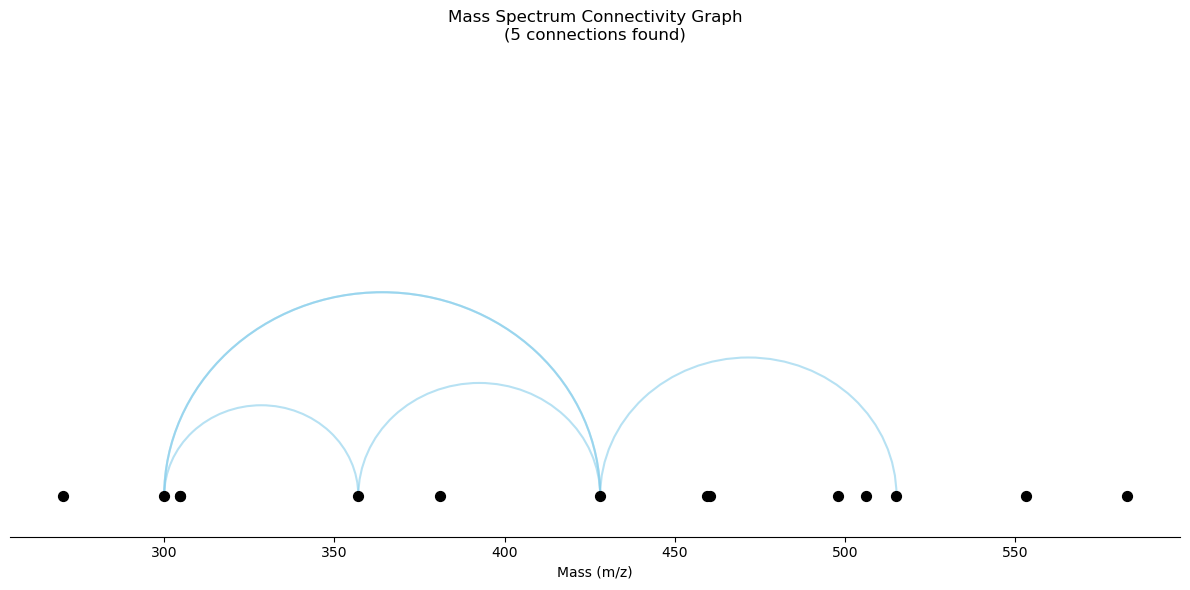

In [19]:
if __name__ == "__main__":
    # 1. Create some mock data
    # Start with a 'seed' mass
    seed_mass = 300.0
    mock_peaks = [seed_mass]

    # Artificially create a peptide sequence: Gly-Ala-Ser
    # Add peaks that definitely have connections
    m1 = seed_mass + AA_MASSES['G']       # + Glycine
    m2 = m1 + AA_MASSES['A']              # + Alanine
    m3 = m2 + AA_MASSES['S']              # + Serine
    mock_peaks.extend([m1, m2, m3])

    # Add some random "noise" peaks that likely won't connect
    np.random.seed(42) # for reproducible noise
    noise_peaks = np.random.uniform(250, 600, 10).tolist()
    mock_peaks.extend(noise_peaks)

    # 2. Run the analysis
    # Sort them (good practice, though the function does it too)
    my_peaks = sorted(mock_peaks)
    print(f"Analyzing {len(my_peaks)} peaks...")

    # Find connections with a tolerance of 0.05 Daltons
    my_connections = find_connections(my_peaks, tolerance=0.05)

    # Print found connections to console
    print("\nConnections Found:")
    for start, end, aa in my_connections:
        print(f"  {start:.2f} -> {end:.2f} (diff: {end-start:.2f}) = {aa}")

    # 3. Generate the visualization
    plot_arc_graph(my_peaks, my_connections)

In [33]:
data = 'ME4_2+'
csv_data = f"{data}.csv"
file_path = os.path.join(
    os.getcwd(),
    f"../data/Top_Correlations_At_Full_Num_Scans_PCov/annotated/{csv_data}"
)
file_path = os.path.abspath(file_path) 

## Store sequence into peptide class
sequence = util.name_ouput(csv_data)
pep = peptide.Pep(sequence)
the_length = len(pep.AA_array)
csv_data = file_path
df = pd.read_csv(csv_data)
df = df[df['Index'].notna()]
results = data_parse.process_ion_dataframe(df.head(50), pep)
results['classification'] = results.apply(data_parse.data_classify, args=(pep,), axis=1)
the_list = []
the_y_list = []

results['loss1'] = results['loss1'].replace({None: np.nan})
results['loss2'] = results['loss2'].replace({None: np.nan})


df = results

/Users/kevinmbp/Desktop/2D_spec_dict/vis_conserve/data_parse.py:259: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['y6', 'y5', 'y5', 'y4', 'y4', 'y6', 'y3', 'y3', 'y5', 'y2', 'y2', 'y3', 'y6', 'y4', 'y6', 'y5', 'y4']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_current.loc[df_current['type1'] == 'y', ['y_ion', 'y_mz']] = df_current.loc[df_current['type1'] == 'y', ['ion1', 'mass1']].values
/Users/kevinmbp/Desktop/2D_spec_dict/vis_conserve/data_parse.py:260: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['b4', 'b6', 'b6', 'a5', 'b5', 'bi(2-4)', 'bi(3-4)', 'b5', 'b5', 'b6', 'a6', 'b6', 'b3', 'a6', 'a4', 'bi(3-5)', 'b4', 'a4', 'a6', 'b5', 'bi(2-6)', 'a6', 'ai(3-5)']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_current.loc[df_cu

In [34]:
LETTER_ORDER = {ch: i for i, ch in enumerate("abcdefghijklmnopqrstuvwxyz")}
rows = ['Parent','(NH3)','(H2O)', '(NH3)-(H2O)','(H2O)-(NH3)', 'a', '2(H2O)', '2(NH3)']
conserve_line_mass_dict = {'Parent': pep.pep_mass, 'a': pep.pep_mass - 28.0106}
for i in rows:
    if i not in conserve_line_mass_dict:
        conserve_line_mass_dict[i] = pep.pep_mass - neutral_loss_mass.mass_of_loss(i)
print(conserve_line_mass_dict)

def classify_conserve_line(row):
    the_mass = row['chosen_sum']
    for i in conserve_line_mass_dict:
        if the_mass < conserve_line_mass_dict[i] + 1 and the_mass > conserve_line_mass_dict[i] - 1:
            return i
    else:
        return None

df['conserve_line'] = df.apply(classify_conserve_line, axis = 1)

{'Parent': 1525.7877099999998, 'a': 1497.7771099999998, '(NH3)': 1508.7611608988798, '(H2O)': 1507.7771453159698, '(NH3)-(H2O)': 1490.7505962148498, '(H2O)-(NH3)': 1490.7505962148498, '2(H2O)': 1489.7665806319399, '2(NH3)': 1491.7346117977597}


In [35]:
df_conserve = df[df['conserve_line'] == 'Parent']
df_conserve[['correct_mass1', 'correct_mass2']]

,correct_mass1,correct_mass2
0,508.20377,1017.58394
1,685.43549,840.35222
3,712.29364,813.49407
4,571.39256,954.39515
6,500.35545,1025.43226
10,565.22523,960.56248
11,387.27139,1138.51632
17,274.18733,1251.60038
25,345.14044,1180.64727


In [39]:
mass_list = list(df_conserve['correct_mass1']) + list(df_conserve['correct_mass2'])

In [41]:
mass_list = list(set(mass_list))
mass_list.sort()
mass_list

[274.18733000000003,
 345.14044,
 387.27139,
 500.35544999999996,
 508.20377,
 565.22523,
 571.39256,
 685.43549,
 712.29364,
 813.49407,
 840.35222,
 954.39515,
 960.5624799999999,
 1017.58394,
 1025.43226,
 1138.51632,
 1180.64727,
 1251.6003799999999]

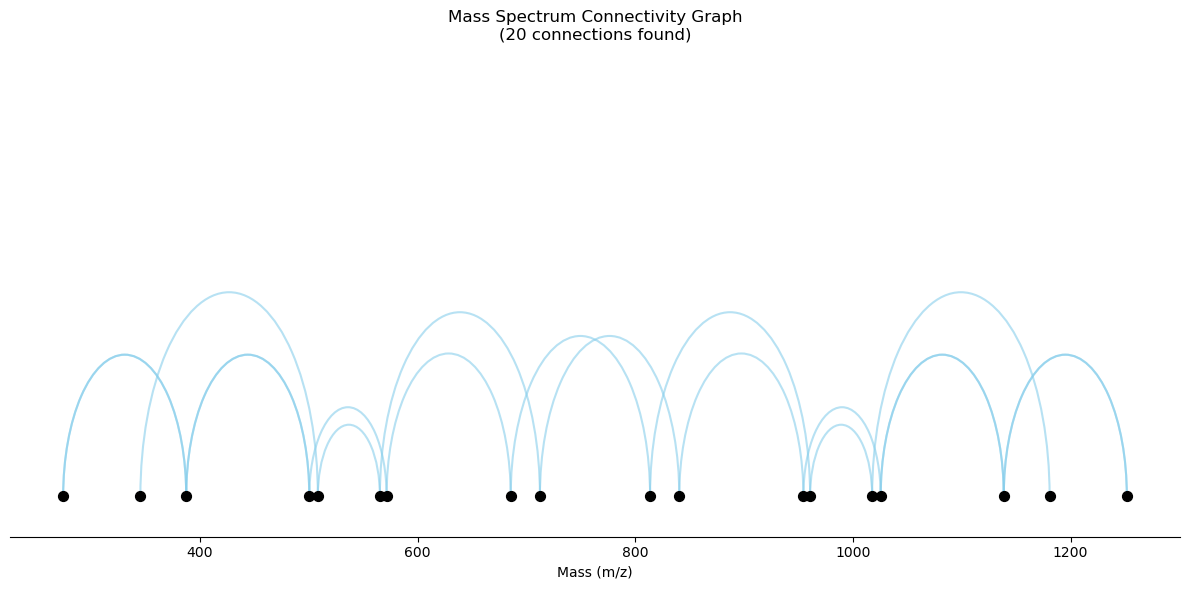

In [46]:
my_peaks = mass_list
my_connections = find_connections(my_peaks, tolerance=0.01)
plot_arc_graph(my_peaks, my_connections)